In [33]:
import requests
from pathlib import Path
from datetime import datetime
import time
import csv
import re, json
from collections import defaultdict
import matplotlib.pyplot as plt


### Verify if the book is already downloaded

In [2]:
CTRL = Path("control")
CTRL.mkdir(exist_ok=True)

LOG_CSV   = CTRL / "control_log.csv"
DOWN_TXT  = CTRL / "downloaded_books.txt"

START_MARKER = "*** START OF THE PROJECT GUTENBERG EBOOK"
END_MARKER   = "*** END OF THE PROJECT GUTENBERG EBOOK"

def already_downloaded(book_id: int) -> bool:
    # 
    return DOWN_TXT.exists() and str(book_id) in DOWN_TXT.read_text(encoding="utf-8").splitlines()

def download_book(book_id: int, base: str = "datalake") -> tuple[Path, Path] | None:
    if already_downloaded(book_id):
        print(f"[SKIP] {book_id} was already downloaded")
        return None
    
    now = datetime.now()
    base_dir = Path(base) / now.strftime("%Y%m%d") / now.strftime("%H")
    base_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    text = resp.text

    if START_MARKER not in text or END_MARKER not in text:
        print(f"[ERROR] Marcadores no encontrados en el libro {book_id}")
        return None

    header, body_and_footer = text.split(START_MARKER, 1)
    body, _footer = body_and_footer.split(END_MARKER, 1)

    header_path = base_dir / f"{book_id}.header.txt"
    body_path   = base_dir / f"{book_id}.body.txt"

    header_path.write_text(header.strip(), encoding="utf-8")
    body_path.write_text(body.strip(), encoding="utf-8")

    print(f"[OK] {book_id} -> {header_path} / {body_path}")
    return header_path, body_path



In [3]:
def register_in_control(book_id: int, header_path: Path, body_path: Path, state="OK"):
    if not LOG_CSV.exists():
        with open(LOG_CSV, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["book_id", "date", "header_file", "body_file", "state"])
    with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            book_id,
            datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            str(header_path),
            str(body_path),
            state
        ])

    with open(DOWN_TXT, "a", encoding="utf-8") as f:
        f.write(f"{book_id}\n")

    print(f"[CONTROL] Registrado {book_id} en control_log.csv y downloaded_books.txt")



In [4]:
def download_multiple(ids: list[int]):
    for bid in ids:
        if already_downloaded(bid):
            print(f"[SKIP] {bid} was already downloaded")
            continue
        res = download_book(bid)  
        if res:
            header_path, body_path = res
            register_in_control(bid, header_path, body_path)  


download_multiple([1342, 11, 84])


[OK] 1342 -> datalake\20251004\10\1342.header.txt / datalake\20251004\10\1342.body.txt
[CONTROL] Registrado 1342 en control_log.csv y downloaded_books.txt
[OK] 11 -> datalake\20251004\10\11.header.txt / datalake\20251004\10\11.body.txt
[CONTROL] Registrado 11 en control_log.csv y downloaded_books.txt
[OK] 84 -> datalake\20251004\10\84.header.txt / datalake\20251004\10\84.body.txt
[CONTROL] Registrado 84 en control_log.csv y downloaded_books.txt


### Converting all the characters to a lowercase text, then we delete all the alphanumeric characters.
    

In [ ]:
DATALAKE_PATH = Path("datalake")
DATAMARTS_PATH = Path("datamarts"); DATAMARTS_PATH.mkdir(exist_ok=True)

def tokenize(text: str) -> list[str]:
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return words

### Strategy 1. Saving the data in datamarts/ as a JSON file

In [11]:

def build_inverted_index1() -> dict[str, set[int]]:
    inverted_index = defaultdict(set)
    for body_file in DATALAKE_PATH.rglob("*.body.txt"):
        book_id = int(body_file.stem.split(".")[0])   
        text = body_file.read_text(encoding="utf-8")
        words = tokenize(text)
        for word in words:
            inverted_index[word].add(book_id)
    return inverted_index


def save_inverted_index(index: dict[str, set[int]]):
    
    json_path = DATAMARTS_PATH / "inverted_index.json"
    serializable_index = {word: list(ids) for word, ids in index.items()}
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(serializable_index, f, ensure_ascii=False, indent=2)
    print(f"[OK] Inverted index saved at {json_path}")


### strategy 2. Saving the data as a txt file

In [12]:
def build_inverted_index2() -> dict[str, set[int]]:
    inverted_index = defaultdict(set)
    for body_file in DATALAKE_PATH.rglob("*.body.txt"):
        book_id = int(body_file.stem.split(".")[0])   
        text = body_file.read_text(encoding="utf-8")
        words = tokenize(text)
        for word in words:
            inverted_index[word].add(book_id)
    return inverted_index

def save_inverted_index_txt(index: dict[str, set[int]]):
    txt_path = DATAMARTS_PATH / "inverted_index.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        for word, ids in sorted(index.items()):
            ids_str = ",".join(map(str, sorted(ids)))
            f.write(f"{word}: {ids_str}\n")
    print(f"[OK] Inverted index saved at {txt_path}")

### Main execution with different types of strategies 

[SKIP] 43 was already downloaded
[SKIP] 56 was already downloaded
[OK] Inverted index saved at datamarts\inverted_index.json
Results for 'love': {43, 11, 84, 1342}
[OK] Inverted index strategy 1
Strategy 1 time '0.2082962989807129'
[OK] Inverted index saved at datamarts\inverted_index.txt
Results for 'love' [txt search]: {43, 11, 84, 1342}
[OK] Inverted index strategy 2
Strategy 2 time '0.20665240287780762'


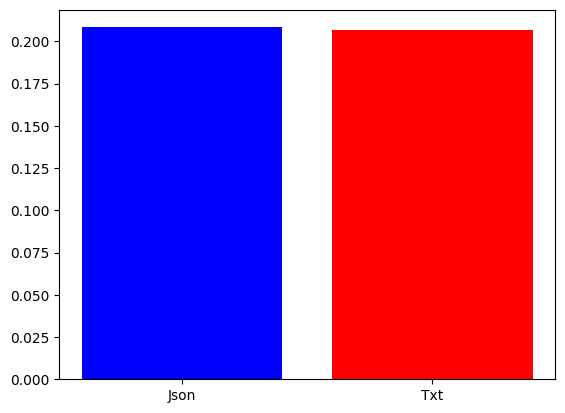

In [44]:
if __name__ == "__main__":

    book_ids = [43, 56]

    for book_id in book_ids:
        if already_downloaded(book_id):   
            print(f"[SKIP] {book_id} was already downloaded")
            continue

        try:
            res = download_book(book_id)
            if res:
                header_file, body_file = res
                register_in_control(book_id, header_file, body_file)
            else:
                register_in_control(book_id, "-", "-", state="FAILED")
        except Exception as e:
            print(f"[ERROR] Failed downloading {book_id}: {e}")
            register_in_control(book_id, "-", "-", state="FAILED")
    word = "love"
    start = time.time()
    inverted_index_strategy1 = build_inverted_index1()
    save_inverted_index(inverted_index_strategy1)
    results = inverted_index_strategy1.get(word.lower(), set())
    end = time.time()
    result_strategy_1 = end - start
    print(f"Results for '{word}': {results}")
    print("[OK] Inverted index strategy 1")
    print(f"Strategy 1 time '{result_strategy_1}'")
    
    start2= time.time()
    inverted_index_strategy2 = build_inverted_index2()
    save_inverted_index_txt(inverted_index_strategy2)
    txt_path = DATAMARTS_PATH / "inverted_index.txt"
    results2 = set()
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith(f"{word.lower()}:"):
                ids_str = line.split(":")[1].strip()
                results2 = set(map(int, ids_str.split(","))) if ids_str else set()
                break

    print(f"Results for '{word}' [txt search]: {results2}")
    end2 = time.time()
    result_strategy_2 = end2 - start2
    print("[OK] Inverted index strategy 2")
    print(f"Strategy 2 time '{result_strategy_2}'")

    plt.bar(["Json", "Txt"] , [result_strategy_1, result_strategy_2], color=["blue", "red"])
    